<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#eca912;
            overflow:hidden;
            font-weight:500">K-Moyennes pour l'analyse sémantique de mots</div>

## <font color='#eca912'>Table des matières<font><a class='anchor' id='toc'></a>
- [1. Import des packages](#packages)
- [2. Import du modèle](#model)
- [3. Visualisation et manipulation des mots](#viz)
- [4. Segmentation des mots](#segmentation)

## <font color=#eca912>1. Import des packages <a class='anchor' id='packages'></a></font>[↑](#toc)

In [3]:
import gensim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
import scipy
import seaborn as sns
import pandas as pd

## <font color=#eca912>2. Import du modèle <a class='anchor' id='model'></a></font>[↑](#toc)

In [5]:
model = gensim.models.KeyedVectors.load_word2vec_format("./modele_Word2Vec.bin", binary=True, unicode_errors="ignore")

## <font color=#eca912>3. Visualisation et manipulation des mots<a class='anchor' id='viz'></a></font>[↑](#toc)

In [6]:
words = np.array(model.index_to_key)
vectors = model.vectors

In [7]:
print(f"Nombre de mots différents: {words.shape}")
print(f"Nombre et dimension des vecteurs associés:{vectors.shape}")

Nombre de mots différents: (155562,)
Nombre et dimension des vecteurs associés:(155562, 200)


Ce sont des mots issus de sites webs en ".fr".

+150 000 mots, transformés en vecteurs de taille 200

In [ ]:
#Analyse en Composante Principale
pca = PCA().fit(vectors)

L'ACP orthogonalise l'espace de vecteurs de sorte à maximiser l'information dans les premières dimensions = les composantes principales. 

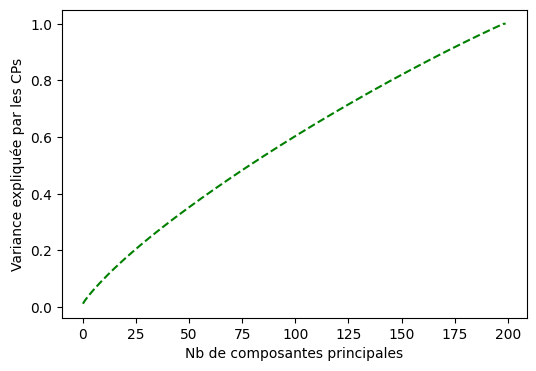

In [9]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(np.cumsum(pca.explained_variance_ratio_), 'g--')
axs.set_ylabel('Variance expliquée par les CPs')
axs.set_xlabel('Nb de composantes principales')
plt.show()

In [41]:
# Création d'un tableau pour montrer précisément les valeurs de conservation d'information
components_to_show = [10, 20, 30, 50, 75, 100, 150, 200]
info_retained = [cumulative_variance[n-1] * 100 for n in components_to_show]

# Afficher les résultats sous forme de tableau
print("\nPourcentage d'information conservée par nombre de composantes :")
for comp, info in zip(components_to_show, info_retained):
    print(f"{comp} composantes (= {comp/2}% des composantes): {info:.2f}%")


Pourcentage d'information conservée par nombre de composantes :
10 composantes (= 5.0% des composantes): 9.33%
20 composantes (= 10.0% des composantes): 16.59%
30 composantes (= 15.0% des composantes): 23.07%
50 composantes (= 25.0% des composantes): 34.71%
75 composantes (= 37.5% des composantes): 47.83%
100 composantes (= 50.0% des composantes): 59.90%
150 composantes (= 75.0% des composantes): 81.59%
200 composantes (= 100.0% des composantes): 100.00%


Analyse des résultats: 

1. Distribution de l'information : 
- Pour atteindre 50% de l'information, il faut 80 composantes sur 200, soit 40% des dimensions originales. 
- Ça montre que l'information est plutôt dispersée à travers les dimensions.

2. Rendement décroissant :
- Les 80 premières composantes capturent 50% de l'information
- Les 55 composantes suivantes (jusqu'à 135) n'ajoutent que 25% d'information supplémentaire
- Les 37 composantes suivantes (jusqu'à 172) n'ajoutent que 15% d'information
- Les 13 dernières composantes (jusqu'à 185) n'ajoutent que 5% d'information


mais... quand même, c'est à peu près linéaire, ce qui veut dire qu'on ne peut pas vraiment compresser davantage l'information. Avec 200 composantes, on a une quantité d'information pertinente, c'est bien construit. Quasi toutes les composantes sont à garder.

## <font color=#eca912>4. Segmentation des mots<a class='anchor' id='segmentation'></a></font>[↑](#toc)

In [10]:
km = KMeans(n_clusters=10, init='k-means++', n_init=1, random_state=91000)

In [11]:
%%time
km = km.fit(vectors)

CPU times: user 8.86 s, sys: 598 ms, total: 9.45 s
Wall time: 1.34 s


In [12]:
np.unique(km.labels_,return_counts=1)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([13342, 13137, 10619, 12312, 30832, 19249, 13185, 14887,  7113,
        20886]))

In [13]:
words[km.labels_==5]

array(['en', 'du', 'par', ..., 'elfi', 'netim', 'mdt'], dtype='<U98')

In [14]:
def trouver_cluster(kmeans: KMeans(), mot: str):
    return kmeans.labels_[model.get_index(mot)]

In [15]:
def afficher_mots_cluster(kmeans: KMeans(), words: np.ndarray, id_cluster: int, n: int = 10):
    return words[kmeans.labels_==id_cluster][:n]

In [16]:
def mots_similaires(kmeans: KMeans(), mot: str, topn: int = 10):
    mots_similaires = model.most_similar(positive=[mot], topn=topn)
    clusters = np.array([(m, sc, trouver_cluster(kmeans, m)) for m, sc in mots_similaires])
    return clusters

In [113]:
trouver_cluster(km, 'fleur')

9

In [115]:
afficher_mots_cluster(km, words, trouver_cluster(km, 'maladie'), n=100)

array(['traitement', 'maladie', 'médecin', 'peau', 'patients',
       'diagnostic', 'espèces', 'maladies', 'cellules', 'facteurs',
       'plantes', 'cancer', 'patient', 'traitements', 'virus',
       'médicaments', 'malades', 'troubles', 'clinique', 'biologie',
       'biologique', 'douleur', 'chimiques', 'cerveau', 'aliments',
       'adulte', 'examens', 'génétique', 'sommeil', 'diminution',
       'substances', 'chimique', 'grossesse', 'stress', 'organique',
       'biologiques', 'plante', 'organes', 'acide', 'mg', 'ml',
       'protéines', 'chirurgie', 'hospitalisation', 'indications', 'adn',
       'molécules', 'prélèvement', 'thérapeutique', 'os', 'grade',
       'composés', 'médicament', 'cliniques', 'substance', 'tissus',
       'secondaires', 'fibres', 'dose', 'huiles', 'imagerie', 'foie',
       'oxygène', 'indication', 'incidence', 'végétaux', 'prescription',
       'moléculaire', 'insectes', 'acides', 'gènes', 'vieillissement',
       'organe', 'symptômes', 'animale', 'cell

Ça marche très bien pour maladie.

In [133]:
afficher_mots_cluster(km, words, trouver_cluster(km, 'hay'), n=100)

array(['#', 'voyage', 'afrique', 'el', 'chine', 'vol', 'match', 'no',
       'île', 'italie', 'espagne', 'finale', 'capitale', 'al', 'los',
       'traduction', 'del', 'rome', 'chinois', 'algérie', 'hotel', 'camp',
       'turquie', 'déjeuner', 'maroc', 'asie', 'aéroport', 'russie',
       'las', 'espagnol', 'inde', 'é', 'arabe', 'frontière', 'province',
       'juifs', 'italien', 'russe', '§', 'allah', 'islam', 'di', 'temple',
       'berlin', 'îles', 'san', 'brésil', 'linguistique', 'buts', 'vols',
       'musulmans', 'nationalité', 'dîner', 'egypte', 'latin', 'iran',
       'opéra', 'josé', 'empereur', 'una', 'pologne', 'arabes',
       'réfugiés', 'liban', 'tunisie', 'portugal', 'grec', 'orient',
       'grèce', 'da', 'li', 'por', 'para', 'italienne', 'chinoise',
       'alger', 'latine', 'madrid', 'mi', 'prophète', 'mexique',
       'autriche', 'pacifique', 'ad', 'milan', 'can', 'olympique',
       'vainqueur', 'barcelone', 'argentine', 'jérusalem', 'do', 'der',
       'antique', 

In [94]:
model.most_similar('fleur')

[('pétales', 0.7091421484947205),
 ('orchidée', 0.6780675649642944),
 ('pétale', 0.6706686615943909),
 ('fleurs', 0.6681479215621948),
 ('tulipe', 0.649394690990448),
 ('chrysanthème', 0.6425840854644775),
 ('rose', 0.6412376761436462),
 ('fleurit', 0.6052149534225464),
 ('jasmin', 0.6042757034301758),
 ('lys', 0.6012750864028931)]

Ça marche très bien pour fleur.

In [134]:
model.most_similar('maladie')

[('incurable', 0.6708134412765503),
 ('neurodégénérative', 0.6285406351089478),
 ('alzheimer', 0.6073530316352844),
 ('maladies', 0.5668352842330933),
 ('assurance', 0.5577492713928223),
 ('cnamts', 0.5450106859207153),
 ('diagnostiquée', 0.5407942533493042),
 ('ald', 0.5399412512779236),
 ('invalidante', 0.5342087149620056),
 ('curable', 0.5283808708190918)]

Ça marche très bien pour maladie.

In [143]:
model.most_similar('enfermedad')

[('muy', 0.5672058463096619),
 ('competencia', 0.5590075850486755),
 ('experiencia', 0.5581974387168884),
 ('astrología', 0.5524370074272156),
 ('propia', 0.5488606095314026),
 ('único', 0.5454645156860352),
 ('manera', 0.5420976281166077),
 ('representa', 0.5397042036056519),
 ('esta', 0.5382519960403442),
 ('llamado', 0.5348697900772095)]

De prime abord, on peut se dire que ça ne marche pas car ça ne met pas des mots du lexique de la maladie en espagnol.
Mais en fait, comme c'est un corpus issu de sites web en français, ça a mis tous les mots espagnols ensemble!


In [142]:
mots_similaires(km, 'épagneul', topn=5)

array([['epagneul', '0.7329717874526978', '0'],
       ['chienne', '0.6023692488670349', '0'],
       ['chiot', '0.5978718996047974', '0'],
       ['chien', '0.5786705613136292', '0'],
       ['labrador', '0.5748332142829895', '0']], dtype='<U32')

Ça marche très bien pour épagneul aussi :D

In [138]:
mots_similaires(km, 'je', topn=10)

array([['me', '0.9032889008522034', '0'],
       ['suis', '0.8511512279510498', '0'],
       ["m'", '0.8405840396881104', '0'],
       ["j'", '0.8162933588027954', '0'],
       ['moi', '0.8143643140792847', '0'],
       ['sais', '0.8072934746742249', '0'],
       ['mon', '0.784636378288269', '0'],
       ['crois', '0.7565917372703552', '0'],
       ['connais', '0.7471164464950562', '0'],
       ['ma', '0.7428123950958252', '0']], dtype='<U32')

C'est vraiment très fort.

In [139]:
sub_words = words[km.labels_==trouver_cluster(km, 'maladie')]
sub_vectors = vectors[km.labels_==trouver_cluster(km, 'maladie')]

In [140]:
%%time
sub_km = KMeans(n_clusters = 10, init='k-means++', random_state=91000)
sub_km = sub_km.fit(sub_vectors)

CPU times: user 626 ms, sys: 152 ms, total: 779 ms
Wall time: 118 ms


In [98]:
np.unique(sub_km.labels_, return_counts=1)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([   2, 1075,  628,  597,  853,  576,  746,  922,  774,  940]))

In [99]:
afficher_mots_cluster(sub_km, sub_words, 1, n=30)

array(['traitement', 'médecin', 'diagnostic', 'cancer', 'patient',
       'traitements', 'clinique', 'examens', 'grossesse', 'chirurgie',
       'hospitalisation', 'indications', 'prélèvement', 'thérapeutique',
       'grade', 'cliniques', 'imagerie', 'foie', 'indication',
       'dépistage', 'cancers', 'greffe', 'accouchement', 'tumeur',
       'anomalies', 'complications', 'tumeurs', 'observée', 'opératoire',
       'anesthésie'], dtype='<U98')

Recherche de représentant des clusters

In [100]:
def get_similarity_matrix(kmeans: KMeans(), words: np.ndarray, id_cluster: int):
    
    N = sum(kmeans.labels_==id_cluster)
    similarities = np.zeros((N,N))
    words_cluster = words[kmeans.labels_==id_cluster]
    vectors_cluster = np.array([model.get_vector(mot) for mot in words_cluster])
    for id_mot, mot in enumerate(words_cluster):
        similarities[id_mot,:] = model.cosine_similarities(model.get_vector(mot), vectors_cluster)

    return similarities

In [101]:
def trouver_representant(kmeans: KMeans(), words: np.ndarray, id_cluster: int):
    words_cluster = words[kmeans.labels_==id_cluster]
    similarities_matrix = get_similarity_matrix(kmeans, words, id_cluster)
    id_representant = np.argmax(similarities_matrix.mean(axis=1))
    return words_cluster[id_representant]

In [102]:
%%time
trouver_representant(sub_km, sub_words, 6)

CPU times: user 524 ms, sys: 15.1 ms, total: 540 ms
Wall time: 72.3 ms


'oxydation'

OK, c'est assez improbable.

In [103]:
from sklearn_extra.cluster import KMedoids

In [104]:
kmed = KMedoids(n_clusters=10, init='k-medoids++', random_state=91000)

In [105]:
%%time
kmed = kmed.fit(sub_vectors)

CPU times: user 3.57 s, sys: 249 ms, total: 3.82 s
Wall time: 906 ms


In [106]:
np.unique(kmed.labels_,return_counts=1)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([  12,  424,  399,   33,  188,   51, 5346,  317,  186,  157]))

In [107]:
sub_words[kmed.medoid_indices_]

array(['diffuses', 'antipaludéens', 'sévères', 'rétiniens', 'prophylaxie',
       'capsule', 'classiquement', 'peau', 'stérilité', 'tissulaire'],
      dtype='<U98')

In [108]:
trouver_representant(kmed, sub_words,8)

'stérilité'